This notebook benchmarks the LO-LARS algorithm [1] on the simulation data set from [2].

The notebook uses LO-LARS to find the piecewise polynomial that computes approximate leave-one-out cross-validation (ALO) exactly for lasso regression and sets the lasso tunning parameter to a local minimum of (ALO).

[1]: Burn, Ryan. Evaluation and optimization of leave-one-out cross-validation. (https://arxiv.org/abs/2508.14368)

[2]: Shuaiwen Wang, Wenda Zhou, Haihao Lu, Arian Maleki, and Vahab Mirrokni.
Approximate leave-one-out for fast parameter tuning in high dimensions. Proceedings of 
the 35th International Conference on Machine Learning, PMLR 80:5228--5237, 2018. (https://arxiv.org/abs/1807.02694)

In [1]:
import numpy as np
import time
from bbai.glm import Lasso, LassoAlo
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
np.seterr(invalid='ignore')

np.random.seed(1234567)

## Generate Data Set

In [2]:
def make_dataset(n, p):
    # Generates the data set described in Appendix F.1.5 of [2].
    
    # X
    K = np.zeros((p, p))
    for j1 in range(p):
        for j2 in range(p):
            K[j1, j2] = 0.8 ** np.abs(j1 - j2)
    X = np.random.multivariate_normal(np.zeros(p), K, size=n)

    # beta
    k = min(n, p) // 2
    beta = np.zeros(p)
    beta[:k] = 2 * np.random.binomial(1, 0.5, size=k) - 1

    # y
    y = np.dot(X, beta) + np.sqrt(0.5) * np.random.normal(size=n)

    return X, y

## Plot Example

Plots an example of the leave-one-out cross-validation (LO) and approximate leave-one-out cross-validation (ALO) curves.

In [3]:
X, y = make_dataset(200, 800) 
alo = LassoAlo(fit_intercept=False, early_exit_threshold=0.05).fit(X, y)
lo = Lasso(fit_intercept=False, loo_mode='lambda').fit(X, y)

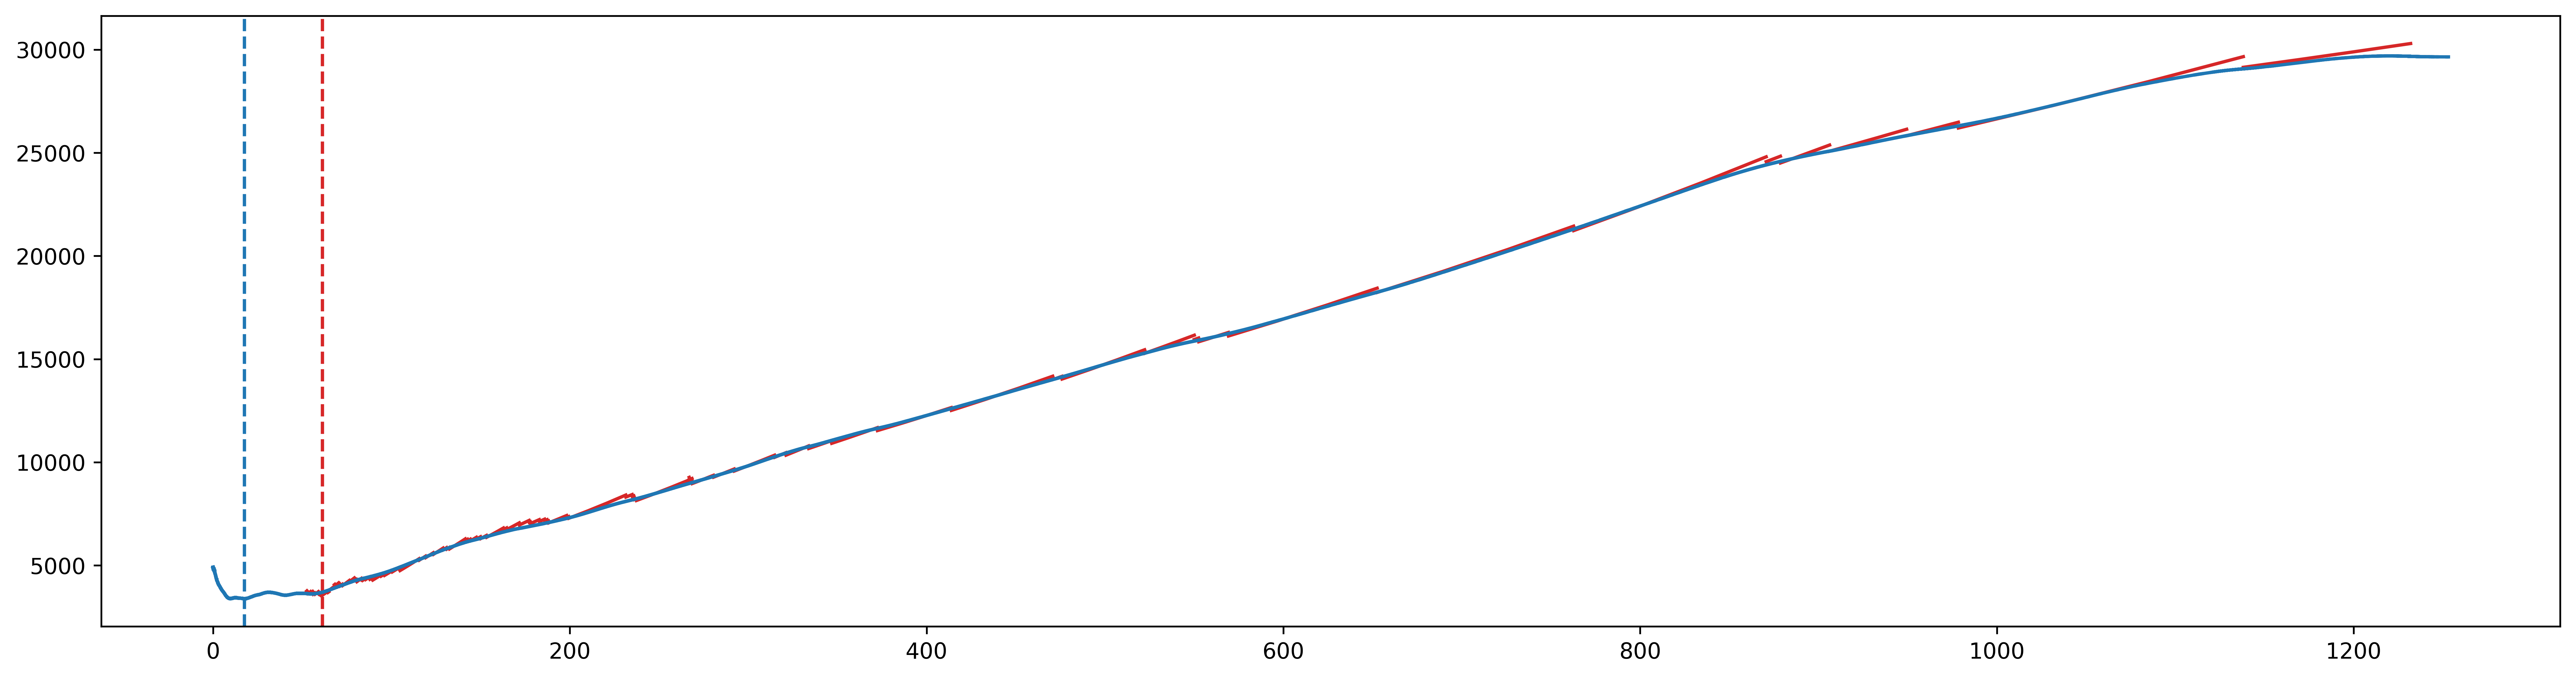

In [4]:
fig, ax = plt.subplots(figsize=(20, 5))
for li, vi in zip(*alo.loo_squared_error_.plot_points()):
    ax.plot(li, vi, color='tab:red')
ax.axvline(alo.lambda_, color='tab:red', linestyle='dashed')
for li, vi in zip(*lo.loo_squared_error_.plot_points()):
    ax.plot(li, vi, color='tab:blue')
ax.axvline(lo.lambda_, color='tab:blue', linestyle='dashed')

The above plot shows the piecewise polynomials that compute LO (blue) and ALO (red) and their minimums (dashed lines). The ALO function is computed until its value exceeds the best minimum by more than 5%.

## Benchmark

Run the benchmark shown in Table 1 of [2].

In [5]:
N = 10
def run_benchmark(n, p):
    res = []
    for _ in range(N):
        X, y = make_dataset(n, p)
        m = LassoAlo(fit_intercept=False, early_exit_threshold=0.05)
        t1 = time.time()
        m.fit(X, y)
        res.append(time.time() - t1)
    return res

In [6]:
n = 800 
print('n\tp\tduration (sec)')
for p in [200, 400, 1600]:
    durations = run_benchmark(n, p)
    print('{}\t{}\t{:.3f} ({:.3f})'.format(n, p, np.mean(durations), np.std(durations, ddof=1)))

n	p	duration (sec)
800	200	0.023 (0.002)
800	400	0.102 (0.015)
800	1600	0.482 (0.113)


In [7]:
p = 800 
print('n\tp\tduration (sec)')
for n in [200, 400, 1600]:
    durations = run_benchmark(n, p)
    print('{}\t{}\t{:.3f} ({:.3f})'.format(n, p, np.mean(durations), np.std(durations, ddof=1)))

n	p	duration (sec)
200	800	0.011 (0.002)
400	800	0.036 (0.008)
1600	800	1.057 (0.120)
